<a href="https://colab.research.google.com/github/sandipautane/mid-capstone/blob/main/ablation_run_tiny_imagenet_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
import zipfile

def download_tiny_imagenet(data_dir='./data'):
    os.makedirs(data_dir, exist_ok=True)
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_path = os.path.join(data_dir, 'tiny-imagenet-200.zip')

    if not os.path.exists(os.path.join(data_dir, 'tiny-imagenet-200')):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        print("Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        os.remove(zip_path)
        print("Done!")
    else:
        print("Tiny ImageNet already downloaded.")

    return os.path.join(data_dir, 'tiny-imagenet-200')


### **Albumentations Transforms**

(https://github.com/albumentations-team/albumentations)

It defines train_tfms using A.Compose to chain together several augmentation techniques from albumentations.

It defines train_tfms using `A.Compose` to chain together several augmentation techniques from albumentations

1. `A.HorizontalFlip`: Randomly flips images horizontally.
2. `A.ShiftScaleRotate`: Applies random affine transformations (shifting, scaling, and rotating).
3. `A.CoarseDropout`: (this is **CutOut**) Randomly drops rectangular regions from the image and fills them with the calculated mean value.
4. `A.Normalize`: Normalizes the pixel values using the pre-computed `MEAN` and `STD`.
5. `ToTensorV2`: Converts the augmented image (which is a NumPy array at this point in the albumentations pipeline) into a PyTorch tensor and moves the channel dimension to the front (C, H, W).

`AlbuTinyImageNet` Dataset Class: It creates a custom Dataset class AlbuCIFAR that wraps the standard tiny imagenet dataset. T**his is necessary because albumentations works with NumPy arrays in HWC (Height, Width, Channel) format, while torchvision datasets return PIL Images (which are converted to tensors in C, H, W format by their default ToTensor)**. The __getitem__ method converts the PIL Image to a NumPy array before applying the albumentations transform.





In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os

# ImageNet normalization stats (standard for ImageNet-based datasets)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Convert to 0..255 for fill_value
fill_value_255 = tuple(int(m * 255) for m in MEAN)

def get_train_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
        A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
                        min_holes=1, min_height=int(image_size*0.25), min_width=int(image_size*0.25),
                        fill_value=fill_value_255, p=0.5),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

def get_val_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

class AlbuTinyImageNet(Dataset):
    def __init__(self, root, train=True, transform=None):
        split = 'train' if train else 'val'
        self.ds = datasets.ImageFolder(os.path.join(root, split))
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]  # PIL Image
        img = np.array(img)        # -> HWC uint8 RGB
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        return img, label


In [3]:
def get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2):
    """
    Create train and validation dataloaders for Tiny ImageNet

    Args:
        data_path: Path to tiny-imagenet-200 directory
        batch_size: Batch size for training
        image_size: Target image size (64 for now, 224 for later)
        num_workers: Number of worker processes
    """
    train_tfms = get_train_transforms(image_size)
    val_tfms = get_val_transforms(image_size)

    train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=train_tfms)
    val_ds = AlbuTinyImageNet(root=data_path, train=False, transform=val_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True,persistent_workers=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True,persistent_workers=True)

    return train_loader, val_loader


In [4]:
import os
import shutil

def reorganize_val_folder(data_path):
    """Reorganize Tiny ImageNet validation folder to work with ImageFolder"""
    val_dir = os.path.join(data_path, 'val')
    img_dir = os.path.join(val_dir, 'images')
    annotations_file = os.path.join(val_dir, 'val_annotations.txt')

    # Read annotations
    with open(annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_name = parts[0]
            class_id = parts[1]

            # Create class folder if it doesn't exist
            class_folder = os.path.join(val_dir, class_id)
            os.makedirs(class_folder, exist_ok=True)

            # Move image to class folder
            src = os.path.join(img_dir, img_name)
            dst = os.path.join(class_folder, img_name)
            if os.path.exists(src):
                shutil.move(src, dst)

    # Remove empty images folder
    if os.path.exists(img_dir) and not os.listdir(img_dir):
        os.rmdir(img_dir)

    print("Validation folder reorganized successfully!")

In [5]:
# Download data
data_path = download_tiny_imagenet()

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

Tiny ImageNet already downloaded.


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


**Quick sanity check**

In [6]:
# Peek a batch and verify normalization stats roughly centered
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| dtype:", imgs.dtype, "| range ~", (imgs.min().item(), imgs.max().item()))
print("Per-channel mean (batch):", imgs.mean(dim=(0,2,3)))
print("Per-channel std  (batch):", imgs.std(dim=(0,2,3)))

Batch shape: torch.Size([128, 3, 64, 64]) | dtype: torch.float32 | range ~ (-2.1179039478302, 2.6399998664855957)
Per-channel mean (batch): tensor([-0.1004, -0.1464, -0.1136])
Per-channel std  (batch): tensor([1.2499, 1.2111, 1.2471])


**Helper: denormalize + show grid**

In [7]:
# Utils to denormalize and visualize a small grid of images
import math
import torch
import matplotlib.pyplot as plt

# Use MEAN/STD computed earlier (lists) and make tensors for broadcasting
_MEAN = torch.tensor(MEAN).view(1, 3, 1, 1)
_STD  = torch.tensor(STD).view(1, 3, 1, 1)

def denorm(imgs):
    """imgs: tensor [B,C,H,W] normalized with MEAN/STD -> return in [0,1]"""
    x = imgs.clone().cpu()
    x = x * _STD + _MEAN
    return x.clamp(0.0, 1.0)

def show_batch(images, labels, class_names, n=16, cols=8):
    """
    Show n images with titles (class names) in a grid.
    images: [B,C,H,W] tensor (normalized)
    labels: [B] tensor
    """
    n = min(n, images.size(0))
    rows = math.ceil(n / cols)
    imgs = denorm(images[:n])

    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i in range(n):
        img = imgs[i].permute(1, 2, 0).numpy()  # HWC
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(class_names[int(labels[i])], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


**View a random training batch (with augmentations)**

/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


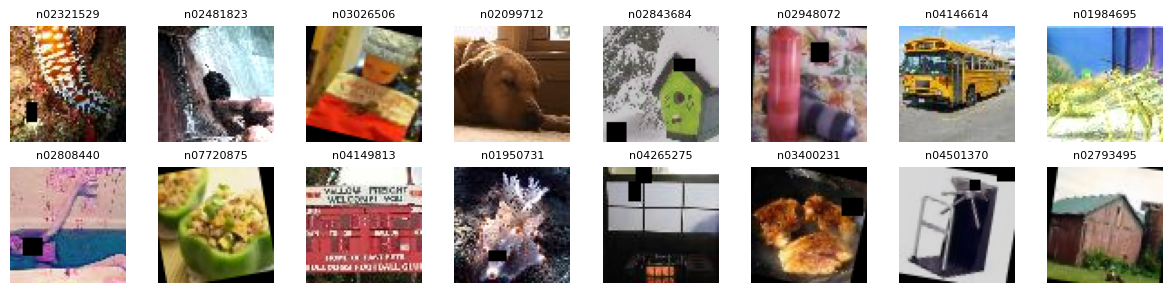

In [8]:
import matplotlib.pyplot as plt

train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=get_train_transforms(64))
class_names = train_ds.ds.classes


def show_batch(images, labels, class_names, n=16, cols=8):
    """Display a batch of images with their labels."""
    n = min(n, len(images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # CHW -> HWC
        img = img * np.array(STD) + np.array(MEAN)  # denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display batch
train_images, train_labels = next(iter(train_loader))
show_batch(train_images, train_labels, class_names, n=16, cols=8)


**View a random test batch (no augmentations)**

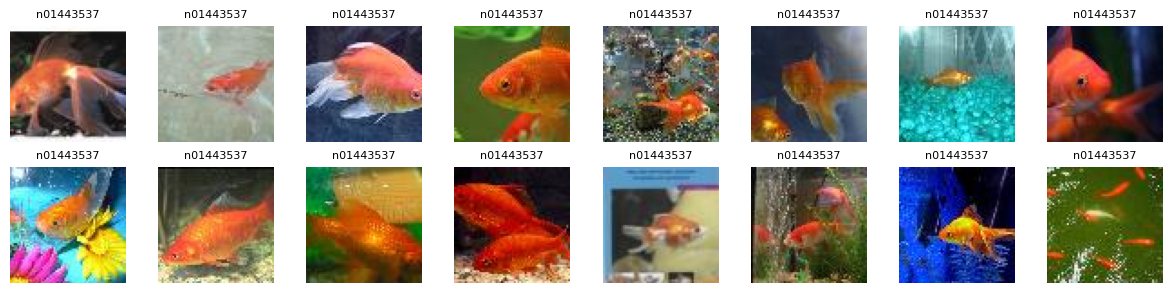

In [9]:
val_images, val_labels = next(iter(val_loader))
show_batch(val_images, val_labels, class_names, n=16, cols=8)

In [10]:
import numpy as np

def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
def cutmix_data(x, y, alpha=1.0, device='cuda'):
    '''Returns CutMix inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # Get random box
    W = x.size()[2]
    H = x.size()[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform sampling
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Apply cutmix
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


In [12]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}


In [13]:
import copy
import torch
import torch.nn.functional as F
from tqdm import tqdm

# keep your history lists (now store epoch-level stats)
train_losses, test_losses = [], []
train_acc,    test_acc    = [], []

class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-4, restore_best_weights=True, checkpoint_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.checkpoint_path = checkpoint_path
        self.best = float('inf')
        self.wait = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_state = copy.deepcopy(model.state_dict())
            if self.checkpoint_path:
                torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.wait += 1
        return self.wait >= self.patience

    def load_best(self, model):
        if self.restore_best_weights and self.best_state is not None:
            model.load_state_dict(self.best_state)
        elif self.checkpoint_path:
            model.load_state_dict(torch.load(self.checkpoint_path, map_location="cpu"))

# mix precision training loop with gradient clipping

from torch.cuda.amp import autocast, GradScaler

def train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2):
    model.train()
    pbar = tqdm(train_loader, desc=f"Train E{epoch:02d}")
    correct, total = 0, 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        # Apply mixup
        if np.random.random() > 0.5:
            data, targets_a, targets_b, lam = mixup_data(data, target, mixup_alpha, device)
        else:
            data, targets_a, targets_b, lam = cutmix_data(data, target, 1.0, device)

        optimizer.zero_grad()

        with autocast():
            y_pred = model(data)
            loss = mixup_criterion(
                lambda pred, y: F.cross_entropy(pred, y, label_smoothing=0.1),
                y_pred, targets_a, targets_b, lam
            )

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Update EMA
        ema.update()

        # stats
        running_loss += loss.item() * data.size(0)
        pred = y_pred.argmax(dim=1)
        correct += (lam * pred.eq(targets_a).sum().float()
                    + (1 - lam) * pred.eq(targets_b).sum().float()).item()
        total += data.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    return epoch_loss, epoch_acc


def test(model, device, test_loader, epoch=None):
    model.eval()
    test_loss_sum, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum', label_smoothing=0.1)  # sum over batch
            test_loss_sum += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.size(0)

    avg_loss = test_loss_sum / total
    acc = 100.0 * correct / total
    test_losses.append(avg_loss)
    test_acc.append(acc)

    if epoch is not None:
        print(f"\nVal E{epoch:02d}: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")
    else:
        print(f"\nVal: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")

    return avg_loss, acc


### ResNet with ReLu with conv instead of fc

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """Original ResNet Basic Block"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)  # ReLU after addition!

        return out


class BottleneckBlock(nn.Module):
    """Original ResNet Bottleneck Block"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample

    def forward(self, x):
      identity = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = F.relu(out, inplace=True)

      out = self.conv2(out)  # <- Fixed: was self.conv2(x)
      out = self.bn2(out)
      out = F.relu(out, inplace=True)

      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample is not None:
          identity = self.downsample(x)

      out += identity
      out = F.relu(out, inplace=True)

      return out



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = torch.flatten(x, 1)

        return x

# Factory functions

def resnet50_with_relu_conv(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def drop_path(x, drop_prob=0.0, training=False):
    """Drop paths (Stochastic Depth) per sample."""
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x.div(keep_prob) * random_tensor
    return output

class BasicBlock(nn.Module):
    """Original ResNet Basic Block with Stochastic Depth"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.drop_prob = drop_prob

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = drop_path(out, self.drop_prob, self.training)
        out += identity
        out = F.relu(out, inplace=True)

        return out


class BottleneckBlock(nn.Module):
    """Original ResNet Bottleneck Block with Stochastic Depth"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample
        self.drop_prob = drop_prob

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out, inplace=True)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = drop_path(out, self.drop_prob, self.training)
        out += identity
        out = F.relu(out, inplace=True)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, drop_path_rate=0.2):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Calculate total number of blocks
        total_blocks = sum(layers)
        # Linear drop path rate schedule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]

        # Track current block index
        block_idx = 0

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1,
                                       drop_probs=dpr[block_idx:block_idx+layers[0]])
        block_idx += layers[0]

        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[1]])
        block_idx += layers[1]

        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[2]])
        block_idx += layers[2]

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[3]])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

    def _make_layer(self, block, out_channels, blocks, stride, drop_probs):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, drop_probs[0]))
        self.in_channels = out_channels * block.expansion

        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, drop_prob=drop_probs[i]))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = torch.flatten(x, 1)

        return x

def resnet50(num_classes=1000, drop_path_rate=0.2):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes, drop_path_rate)


### model & model summary

In [16]:
# model = resnet50_with_relu(num_classes=200)
# model = resnet50(num_classes=200)
# model = resnet50_with_relu_conv(num_classes=200)
model = resnet50(num_classes=1000, drop_path_rate=0.2)

In [17]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]           4,096
       BatchNorm2d-5             [-1, 64, 8, 8]             128
            Conv2d-6             [-1, 64, 8, 8]          36,864
       BatchNorm2d-7             [-1, 64, 8, 8]             128
            Conv2d-8            [-1, 256, 8, 8]          16,384
       BatchNorm2d-9            [-1, 256, 8, 8]             512
           Conv2d-10            [-1, 256, 8, 8]          16,384
      BatchNorm2d-11            [-1, 256, 8, 8]             512
  BottleneckBlock-12            [-1, 256, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          16,384
      BatchNorm2d-14             [

### Finding the learning rate for OneCylePolicy LR Scheduler

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.19E-05


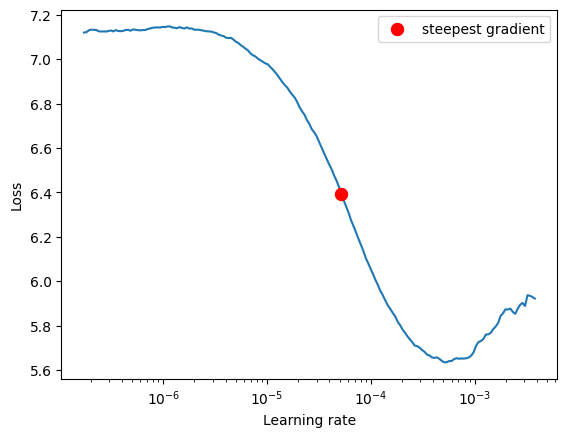

In [18]:
# Install if needed
!pip install torch-lr-finder

import torch.optim as optim
from torch_lr_finder import LRFinder

# Create fresh model and optimizer
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Run LR finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=0.005, num_iter=200)
lr_finder.plot()  # Shows the loss vs learning rate
lr_finder.reset()  # Reset model and optimizer

### **run it!! - reorganize validation files (important to run once)**

In [19]:
# Run it
reorganize_val_folder(data_path)

Validation folder reorganized successfully!


### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3

**Observation**: new high accuracy of ~ 50% was reached
tried running with EMA but accuracy was stuck at 0.5% maybe decay param is wrong

In [20]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

scaler = GradScaler()
ema = EMA(model, decay=0.9999)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler)

    # Use EMA weights for validation
    ema.apply_shadow()
    val_loss, val_acc = test(model, device, val_loader, epoch)
    ema.restore()

    # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")

Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/tmp/ipython-input-3863602024.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-4279722476.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will resu


Val E01: loss=5.4367, acc=42/10000 (0.42%)



Train E02: 100%|██████████| 782/782 [01:46<00:00,  7.31it/s, acc=3.46%, loss=4.9637]



Val E02: loss=5.4781, acc=49/10000 (0.49%)



Train E03: 100%|██████████| 782/782 [01:45<00:00,  7.40it/s, acc=6.32%, loss=4.5470]



Val E03: loss=5.4548, acc=50/10000 (0.50%)



Train E04: 100%|██████████| 782/782 [01:44<00:00,  7.49it/s, acc=8.68%, loss=4.3162]



Val E04: loss=5.4499, acc=57/10000 (0.57%)



Train E05: 100%|██████████| 782/782 [01:45<00:00,  7.41it/s, acc=11.22%, loss=3.5849]



Val E05: loss=5.4471, acc=49/10000 (0.49%)



Train E06: 100%|██████████| 782/782 [01:48<00:00,  7.23it/s, acc=12.70%, loss=4.1874]



Val E06: loss=5.4103, acc=58/10000 (0.58%)



Train E07: 100%|██████████| 782/782 [01:46<00:00,  7.35it/s, acc=14.10%, loss=4.2118]



Val E07: loss=5.4091, acc=53/10000 (0.53%)



Train E08: 100%|██████████| 782/782 [01:45<00:00,  7.41it/s, acc=15.93%, loss=5.0271]



Val E08: loss=5.3967, acc=58/10000 (0.58%)



Train E09: 100%|██████████| 782/782 [01:44<00:00,  7.45it/s, acc=16.99%, loss=5.0625]



Val E09: loss=5.3576, acc=50/10000 (0.50%)



Train E10: 100%|██████████| 782/782 [01:46<00:00,  7.36it/s, acc=17.32%, loss=3.6404]



Val E10: loss=5.3498, acc=50/10000 (0.50%)



Train E11: 100%|██████████| 782/782 [01:45<00:00,  7.41it/s, acc=18.50%, loss=4.6925]



Val E11: loss=5.3514, acc=50/10000 (0.50%)



Train E12: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s, acc=19.73%, loss=4.7043]



Val E12: loss=5.3604, acc=64/10000 (0.64%)



Train E13: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s, acc=20.78%, loss=4.6330]



Val E13: loss=5.3849, acc=50/10000 (0.50%)



Train E14: 100%|██████████| 782/782 [01:41<00:00,  7.69it/s, acc=21.46%, loss=3.3773]



Val E14: loss=5.3816, acc=69/10000 (0.69%)



Train E15: 100%|██████████| 782/782 [01:41<00:00,  7.69it/s, acc=21.91%, loss=3.6061]



Val E15: loss=5.4192, acc=51/10000 (0.51%)



Train E16: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=22.37%, loss=4.1963]



Val E16: loss=5.4245, acc=64/10000 (0.64%)



Train E17: 100%|██████████| 782/782 [01:40<00:00,  7.81it/s, acc=23.48%, loss=4.9225]



Val E17: loss=5.4702, acc=50/10000 (0.50%)



Train E18: 100%|██████████| 782/782 [01:41<00:00,  7.72it/s, acc=24.76%, loss=4.4926]



Val E18: loss=5.4548, acc=50/10000 (0.50%)



Train E19: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=25.79%, loss=4.7151]



Val E19: loss=5.4799, acc=67/10000 (0.67%)



Train E20: 100%|██████████| 782/782 [01:41<00:00,  7.71it/s, acc=27.18%, loss=4.0884]



Val E20: loss=5.4850, acc=54/10000 (0.54%)



Train E21: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=26.51%, loss=4.0472]



Val E21: loss=5.5715, acc=58/10000 (0.58%)

✓ Saved best model at epoch 21 with accuracy: 0.58%


Train E22: 100%|██████████| 782/782 [01:41<00:00,  7.71it/s, acc=27.98%, loss=4.2280]



Val E22: loss=5.6283, acc=52/10000 (0.52%)



Train E23: 100%|██████████| 782/782 [01:40<00:00,  7.75it/s, acc=29.38%, loss=4.0743]



Val E23: loss=5.6139, acc=52/10000 (0.52%)



Train E24: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=30.14%, loss=6.0392]



Val E24: loss=5.6999, acc=86/10000 (0.86%)

✓ Saved best model at epoch 24 with accuracy: 0.86%


Train E25: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=31.38%, loss=3.6274]



Val E25: loss=5.7176, acc=61/10000 (0.61%)



Train E26: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=31.88%, loss=3.3135]



Val E26: loss=5.9410, acc=62/10000 (0.62%)



Train E27: 100%|██████████| 782/782 [01:41<00:00,  7.69it/s, acc=32.62%, loss=3.8155]



Val E27: loss=6.0143, acc=74/10000 (0.74%)



Train E28: 100%|██████████| 782/782 [01:41<00:00,  7.67it/s, acc=33.40%, loss=4.3460]



Val E28: loss=6.2900, acc=66/10000 (0.66%)



Train E29: 100%|██████████| 782/782 [01:42<00:00,  7.65it/s, acc=34.69%, loss=4.3606]



Val E29: loss=6.2532, acc=63/10000 (0.63%)



Train E30: 100%|██████████| 782/782 [01:41<00:00,  7.67it/s, acc=36.30%, loss=3.4031]



Val E30: loss=6.4007, acc=86/10000 (0.86%)



Train E31: 100%|██████████| 782/782 [01:40<00:00,  7.79it/s, acc=36.67%, loss=3.4710]



Val E31: loss=6.2894, acc=64/10000 (0.64%)



Train E32: 100%|██████████| 782/782 [01:39<00:00,  7.84it/s, acc=37.72%, loss=4.8964]



Val E32: loss=6.9135, acc=61/10000 (0.61%)



Train E33: 100%|██████████| 782/782 [01:42<00:00,  7.65it/s, acc=38.42%, loss=3.8851]



Val E33: loss=5.9947, acc=170/10000 (1.70%)

✓ Saved best model at epoch 33 with accuracy: 1.70%


Train E34: 100%|██████████| 782/782 [01:43<00:00,  7.57it/s, acc=40.13%, loss=4.1262]



Val E34: loss=6.4176, acc=106/10000 (1.06%)



Train E35: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=42.00%, loss=4.0659]



Val E35: loss=5.8559, acc=192/10000 (1.92%)

✓ Saved best model at epoch 35 with accuracy: 1.92%


Train E36: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=42.56%, loss=2.4639]



Val E36: loss=6.2322, acc=111/10000 (1.11%)



Train E37: 100%|██████████| 782/782 [01:39<00:00,  7.83it/s, acc=42.99%, loss=4.0079]



Val E37: loss=5.7656, acc=247/10000 (2.47%)

✓ Saved best model at epoch 37 with accuracy: 2.47%


Train E38: 100%|██████████| 782/782 [01:41<00:00,  7.71it/s, acc=43.63%, loss=3.5705]



Val E38: loss=5.8828, acc=217/10000 (2.17%)



Train E39: 100%|██████████| 782/782 [01:41<00:00,  7.69it/s, acc=45.41%, loss=4.3398]



Val E39: loss=5.5339, acc=313/10000 (3.13%)

✓ Saved best model at epoch 39 with accuracy: 3.13%


Train E40: 100%|██████████| 782/782 [01:40<00:00,  7.81it/s, acc=44.82%, loss=3.8946]



Val E40: loss=5.5763, acc=277/10000 (2.77%)



Train E41: 100%|██████████| 782/782 [01:41<00:00,  7.69it/s, acc=45.99%, loss=2.8149]



Val E41: loss=5.1761, acc=506/10000 (5.06%)

✓ Saved best model at epoch 41 with accuracy: 5.06%


Train E42: 100%|██████████| 782/782 [01:42<00:00,  7.61it/s, acc=47.19%, loss=4.1732]



Val E42: loss=4.8095, acc=861/10000 (8.61%)

✓ Saved best model at epoch 42 with accuracy: 8.61%


Train E43: 100%|██████████| 782/782 [01:42<00:00,  7.65it/s, acc=46.94%, loss=2.3362]



Val E43: loss=4.9435, acc=832/10000 (8.32%)



Train E44: 100%|██████████| 782/782 [01:40<00:00,  7.79it/s, acc=48.16%, loss=5.3672]



Val E44: loss=4.6319, acc=1135/10000 (11.35%)

✓ Saved best model at epoch 44 with accuracy: 11.35%


Train E45: 100%|██████████| 782/782 [01:41<00:00,  7.74it/s, acc=48.88%, loss=4.2692]



Val E45: loss=4.7570, acc=1004/10000 (10.04%)



Train E46: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=49.85%, loss=2.3636]



Val E46: loss=4.3254, acc=1507/10000 (15.07%)

✓ Saved best model at epoch 46 with accuracy: 15.07%


Train E47: 100%|██████████| 782/782 [01:41<00:00,  7.74it/s, acc=49.89%, loss=10.4380]



Val E47: loss=4.2321, acc=1800/10000 (18.00%)

✓ Saved best model at epoch 47 with accuracy: 18.00%


Train E48: 100%|██████████| 782/782 [01:41<00:00,  7.74it/s, acc=51.54%, loss=1.8063]



Val E48: loss=4.1182, acc=1938/10000 (19.38%)

✓ Saved best model at epoch 48 with accuracy: 19.38%


Train E49: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=52.11%, loss=4.3770]



Val E49: loss=4.2679, acc=1699/10000 (16.99%)



Train E50: 100%|██████████| 782/782 [01:42<00:00,  7.63it/s, acc=52.84%, loss=2.7760]



Val E50: loss=4.0526, acc=2038/10000 (20.38%)

✓ Saved best model at epoch 50 with accuracy: 20.38%


Train E51: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s, acc=52.64%, loss=2.8574]



Val E51: loss=3.6201, acc=2899/10000 (28.99%)

✓ Saved best model at epoch 51 with accuracy: 28.99%


Train E52: 100%|██████████| 782/782 [01:40<00:00,  7.79it/s, acc=53.84%, loss=4.0484]



Val E52: loss=3.3943, acc=3332/10000 (33.32%)

✓ Saved best model at epoch 52 with accuracy: 33.32%


Train E53: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=56.45%, loss=2.9906]



Val E53: loss=3.2335, acc=3741/10000 (37.41%)

✓ Saved best model at epoch 53 with accuracy: 37.41%


Train E54: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s, acc=56.52%, loss=6.4963]



Val E54: loss=3.2175, acc=3765/10000 (37.65%)

✓ Saved best model at epoch 54 with accuracy: 37.65%


Train E55: 100%|██████████| 782/782 [01:40<00:00,  7.77it/s, acc=54.81%, loss=2.4913]



Val E55: loss=3.2886, acc=3719/10000 (37.19%)



Train E56: 100%|██████████| 782/782 [01:42<00:00,  7.62it/s, acc=56.44%, loss=9.3936]



Val E56: loss=3.0674, acc=4143/10000 (41.43%)

✓ Saved best model at epoch 56 with accuracy: 41.43%


Train E57: 100%|██████████| 782/782 [01:43<00:00,  7.58it/s, acc=57.26%, loss=3.8812]



Val E57: loss=3.2843, acc=3904/10000 (39.04%)



Train E58: 100%|██████████| 782/782 [01:47<00:00,  7.31it/s, acc=58.33%, loss=1.5830]



Val E58: loss=3.1497, acc=4226/10000 (42.26%)

✓ Saved best model at epoch 58 with accuracy: 42.26%


Train E59: 100%|██████████| 782/782 [01:45<00:00,  7.41it/s, acc=58.39%, loss=2.5033]



Val E59: loss=3.1817, acc=4367/10000 (43.67%)

✓ Saved best model at epoch 59 with accuracy: 43.67%


Train E60: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s, acc=58.68%, loss=1.6567]



Val E60: loss=2.9746, acc=4584/10000 (45.84%)

✓ Saved best model at epoch 60 with accuracy: 45.84%


Train E61: 100%|██████████| 782/782 [01:44<00:00,  7.49it/s, acc=60.94%, loss=1.7858]



Val E61: loss=2.9494, acc=4550/10000 (45.50%)



Train E62: 100%|██████████| 782/782 [01:44<00:00,  7.50it/s, acc=60.17%, loss=2.8727]



Val E62: loss=2.8329, acc=4846/10000 (48.46%)

✓ Saved best model at epoch 62 with accuracy: 48.46%


Train E63: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s, acc=61.12%, loss=3.3211]



Val E63: loss=2.7767, acc=5011/10000 (50.11%)

✓ Saved best model at epoch 63 with accuracy: 50.11%


Train E64: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s, acc=62.75%, loss=2.3317]



Val E64: loss=2.8074, acc=4944/10000 (49.44%)



Train E65: 100%|██████████| 782/782 [01:44<00:00,  7.52it/s, acc=61.80%, loss=7.3088]



Val E65: loss=2.7737, acc=5005/10000 (50.05%)



Train E66: 100%|██████████| 782/782 [01:45<00:00,  7.39it/s, acc=60.98%, loss=4.2064]



Val E66: loss=2.8341, acc=4960/10000 (49.60%)



Train E67: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s, acc=63.67%, loss=2.1727]



Val E67: loss=2.8087, acc=4976/10000 (49.76%)



Train E68: 100%|██████████| 782/782 [01:44<00:00,  7.52it/s, acc=63.22%, loss=3.7511]



Val E68: loss=2.9621, acc=4922/10000 (49.22%)



Train E69: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s, acc=63.20%, loss=1.2031]



Val E69: loss=2.7478, acc=5125/10000 (51.25%)

✓ Saved best model at epoch 69 with accuracy: 51.25%


Train E70: 100%|██████████| 782/782 [01:45<00:00,  7.41it/s, acc=63.58%, loss=3.4922]



Val E70: loss=2.7841, acc=5165/10000 (51.65%)

✓ Saved best model at epoch 70 with accuracy: 51.65%


Train E71: 100%|██████████| 782/782 [01:45<00:00,  7.39it/s, acc=64.37%, loss=4.0108]



Val E71: loss=2.7628, acc=5129/10000 (51.29%)



Train E72: 100%|██████████| 782/782 [01:44<00:00,  7.50it/s, acc=63.34%, loss=1.2649]



Val E72: loss=2.8110, acc=5096/10000 (50.96%)



Train E73: 100%|██████████| 782/782 [01:43<00:00,  7.53it/s, acc=65.23%, loss=1.1746]



Val E73: loss=2.8137, acc=5042/10000 (50.42%)



Train E74: 100%|██████████| 782/782 [01:43<00:00,  7.58it/s, acc=65.13%, loss=1.9606]



Val E74: loss=2.7138, acc=5226/10000 (52.26%)

✓ Saved best model at epoch 74 with accuracy: 52.26%


Train E75: 100%|██████████| 782/782 [01:43<00:00,  7.58it/s, acc=64.16%, loss=4.1749]



Val E75: loss=2.8415, acc=5011/10000 (50.11%)



Train E76: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s, acc=65.18%, loss=1.3088]



Val E76: loss=2.7112, acc=5208/10000 (52.08%)



Train E77: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=65.43%, loss=1.2334]



Val E77: loss=2.6865, acc=5262/10000 (52.62%)

✓ Saved best model at epoch 77 with accuracy: 52.62%


Train E78: 100%|██████████| 782/782 [01:42<00:00,  7.65it/s, acc=67.00%, loss=2.1583]



Val E78: loss=2.7488, acc=5223/10000 (52.23%)



Train E79: 100%|██████████| 782/782 [01:42<00:00,  7.67it/s, acc=66.75%, loss=1.2210]



Val E79: loss=2.6828, acc=5293/10000 (52.93%)

✓ Saved best model at epoch 79 with accuracy: 52.93%


Train E80: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s, acc=65.69%, loss=7.7767]



Val E80: loss=2.8544, acc=5090/10000 (50.90%)



Train E81: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=67.22%, loss=1.3013]



Val E81: loss=2.7349, acc=5253/10000 (52.53%)



Train E82: 100%|██████████| 782/782 [01:42<00:00,  7.62it/s, acc=67.32%, loss=4.1363]



Val E82: loss=2.8787, acc=5172/10000 (51.72%)



Train E83: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s, acc=66.65%, loss=3.7778]



Val E83: loss=2.7594, acc=5208/10000 (52.08%)



Train E84: 100%|██████████| 782/782 [01:42<00:00,  7.63it/s, acc=65.81%, loss=1.2022]



Val E84: loss=2.7095, acc=5328/10000 (53.28%)

✓ Saved best model at epoch 84 with accuracy: 53.28%


Train E85: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s, acc=68.02%, loss=3.2608]



Val E85: loss=2.7086, acc=5304/10000 (53.04%)



Train E86: 100%|██████████| 782/782 [01:41<00:00,  7.68it/s, acc=69.42%, loss=5.8457]



Val E86: loss=2.6778, acc=5294/10000 (52.94%)



Train E87: 100%|██████████| 782/782 [01:43<00:00,  7.59it/s, acc=67.93%, loss=3.6424]



Val E87: loss=2.8037, acc=5209/10000 (52.09%)



Train E88: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s, acc=69.80%, loss=1.4036]



Val E88: loss=2.7426, acc=5278/10000 (52.78%)



Train E89: 100%|██████████| 782/782 [01:41<00:00,  7.70it/s, acc=68.81%, loss=3.3897]



Val E89: loss=2.7247, acc=5358/10000 (53.58%)

✓ Saved best model at epoch 89 with accuracy: 53.58%


Train E90: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s, acc=68.66%, loss=1.1514]



Val E90: loss=2.6627, acc=5409/10000 (54.09%)

✓ Saved best model at epoch 90 with accuracy: 54.09%


Train E91: 100%|██████████| 782/782 [01:41<00:00,  7.69it/s, acc=69.48%, loss=1.2190]



Val E91: loss=2.6634, acc=5377/10000 (53.77%)



Train E92: 100%|██████████| 782/782 [01:44<00:00,  7.49it/s, acc=67.18%, loss=4.3829]



Val E92: loss=2.6644, acc=5397/10000 (53.97%)



Train E93: 100%|██████████| 782/782 [01:44<00:00,  7.51it/s, acc=68.67%, loss=1.2285]



Val E93: loss=2.6128, acc=5436/10000 (54.36%)

✓ Saved best model at epoch 93 with accuracy: 54.36%


Train E94: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s, acc=67.22%, loss=1.1259]



Val E94: loss=2.6544, acc=5398/10000 (53.98%)



Train E95: 100%|██████████| 782/782 [01:44<00:00,  7.50it/s, acc=69.19%, loss=3.6780]



Val E95: loss=2.6772, acc=5381/10000 (53.81%)



Train E96: 100%|██████████| 782/782 [01:44<00:00,  7.51it/s, acc=69.38%, loss=2.8920]



Val E96: loss=2.6310, acc=5453/10000 (54.53%)

✓ Saved best model at epoch 96 with accuracy: 54.53%


Train E97: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s, acc=69.03%, loss=1.1317]



Val E97: loss=2.6199, acc=5456/10000 (54.56%)

✓ Saved best model at epoch 97 with accuracy: 54.56%


Train E98: 100%|██████████| 782/782 [01:45<00:00,  7.42it/s, acc=68.93%, loss=2.2190]



Val E98: loss=2.6171, acc=5454/10000 (54.54%)



Train E99: 100%|██████████| 782/782 [01:43<00:00,  7.53it/s, acc=69.72%, loss=3.0361]



Val E99: loss=2.6208, acc=5411/10000 (54.11%)



Train E100: 100%|██████████| 782/782 [01:44<00:00,  7.45it/s, acc=67.39%, loss=2.1555]



Val E100: loss=2.6274, acc=5398/10000 (53.98%)


Training complete! Best validation accuracy: 54.56%


### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing**

**Observation**: new high accuracy of ~ 56% was reached
very good overall acceleration of occuracy

In [21]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 30:
        return 64
    elif epoch <= 60:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=2)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




Device: cuda


/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/tmp/ipython-input-3751687398.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Switching to image size: 64x64



Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-4279722476.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Train E01: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s, acc=1.08%, loss=5.2248]



Val E01: loss=5.0622, acc=284/10000 (2.84%)



Train E02: 100%|██████████| 782/782 [01:45<00:00,  7.38it/s, acc=3.72%, loss=4.8221]



Val E02: loss=4.6431, acc=796/10000 (7.96%)



Train E03: 100%|██████████| 782/782 [01:45<00:00,  7.43it/s, acc=6.34%, loss=4.7428]



Val E03: loss=4.4685, acc=1225/10000 (12.25%)



Train E04: 100%|██████████| 782/782 [01:45<00:00,  7.41it/s, acc=9.27%, loss=4.3302]



Val E04: loss=4.1692, acc=1664/10000 (16.64%)



Train E05: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s, acc=11.44%, loss=4.1685]



Val E05: loss=4.0919, acc=1869/10000 (18.69%)



Train E06: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s, acc=12.97%, loss=4.0622]



Val E06: loss=3.9226, acc=2125/10000 (21.25%)



Train E07: 100%|██████████| 782/782 [01:44<00:00,  7.51it/s, acc=14.33%, loss=4.7447]



Val E07: loss=4.0424, acc=2213/10000 (22.13%)



Train E08: 100%|██████████| 782/782 [01:43<00:00,  7.53it/s, acc=15.54%, loss=4.2830]



Val E08: loss=4.1048, acc=2329/10000 (23.29%)



Train E09: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s, acc=16.54%, loss=4.9473]



Val E09: loss=3.6044, acc=2737/10000 (27.37%)



Train E10: 100%|██████████| 782/782 [01:44<00:00,  7.52it/s, acc=17.43%, loss=4.7546]



Val E10: loss=3.6367, acc=2626/10000 (26.26%)



Train E11: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s, acc=18.08%, loss=3.4744]



Val E11: loss=3.6027, acc=2698/10000 (26.98%)



Train E12: 100%|██████████| 782/782 [01:44<00:00,  7.49it/s, acc=19.91%, loss=3.9461]



Val E12: loss=3.6780, acc=2767/10000 (27.67%)



Train E13: 100%|██████████| 782/782 [01:43<00:00,  7.58it/s, acc=20.74%, loss=3.3719]



Val E13: loss=3.5240, acc=2888/10000 (28.88%)



Train E14: 100%|██████████| 782/782 [01:41<00:00,  7.70it/s, acc=21.90%, loss=4.7528]



Val E14: loss=3.4960, acc=3044/10000 (30.44%)



Train E15: 100%|██████████| 782/782 [01:42<00:00,  7.65it/s, acc=22.73%, loss=3.2803]



Val E15: loss=3.3441, acc=3272/10000 (32.72%)



Train E16: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=22.12%, loss=3.9431]



Val E16: loss=3.4221, acc=3188/10000 (31.88%)



Train E17: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=23.41%, loss=4.1007]



Val E17: loss=3.2471, acc=3548/10000 (35.48%)



Train E18: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s, acc=24.96%, loss=3.6851]



Val E18: loss=3.2287, acc=3537/10000 (35.37%)



Train E19: 100%|██████████| 782/782 [01:41<00:00,  7.67it/s, acc=26.14%, loss=4.9057]



Val E19: loss=3.1716, acc=3734/10000 (37.34%)



Train E20: 100%|██████████| 782/782 [01:42<00:00,  7.61it/s, acc=26.67%, loss=4.6007]



Val E20: loss=3.1842, acc=3698/10000 (36.98%)



Train E21: 100%|██████████| 782/782 [01:42<00:00,  7.60it/s, acc=27.75%, loss=4.1102]



Val E21: loss=3.0790, acc=3900/10000 (39.00%)

✓ Saved best model at epoch 21 with accuracy: 39.00%


Train E22: 100%|██████████| 782/782 [01:42<00:00,  7.60it/s, acc=28.20%, loss=3.8135]



Val E22: loss=3.1610, acc=3761/10000 (37.61%)



Train E23: 100%|██████████| 782/782 [01:42<00:00,  7.61it/s, acc=28.55%, loss=4.2609]



Val E23: loss=3.0723, acc=3992/10000 (39.92%)

✓ Saved best model at epoch 23 with accuracy: 39.92%


Train E24: 100%|██████████| 782/782 [01:43<00:00,  7.58it/s, acc=30.79%, loss=3.3152]



Val E24: loss=2.9588, acc=4199/10000 (41.99%)

✓ Saved best model at epoch 24 with accuracy: 41.99%


Train E25: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s, acc=31.15%, loss=4.3508]



Val E25: loss=3.0531, acc=4027/10000 (40.27%)



Train E26: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s, acc=32.15%, loss=4.3267]



Val E26: loss=2.9291, acc=4246/10000 (42.46%)

✓ Saved best model at epoch 26 with accuracy: 42.46%


Train E27: 100%|██████████| 782/782 [01:45<00:00,  7.44it/s, acc=33.22%, loss=2.7767]



Val E27: loss=2.9769, acc=4256/10000 (42.56%)

✓ Saved best model at epoch 27 with accuracy: 42.56%


Train E28: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s, acc=34.12%, loss=2.9852]



Val E28: loss=2.9290, acc=4277/10000 (42.77%)

✓ Saved best model at epoch 28 with accuracy: 42.77%


Train E29: 100%|██████████| 782/782 [01:46<00:00,  7.34it/s, acc=35.21%, loss=2.4202]



Val E29: loss=2.8803, acc=4458/10000 (44.58%)

✓ Saved best model at epoch 29 with accuracy: 44.58%


Train E30: 100%|██████████| 782/782 [01:44<00:00,  7.52it/s, acc=35.66%, loss=3.9083]



Val E30: loss=2.8626, acc=4480/10000 (44.80%)

✓ Saved best model at epoch 30 with accuracy: 44.80%

Switching to image size: 128x128



Train E31: 100%|██████████| 1563/1563 [03:13<00:00,  8.08it/s, acc=28.70%, loss=2.8667]



Val E31: loss=2.9217, acc=4262/10000 (42.62%)



Train E32: 100%|██████████| 1563/1563 [03:16<00:00,  7.97it/s, acc=32.76%, loss=3.0278]



Val E32: loss=2.8114, acc=4599/10000 (45.99%)

✓ Saved best model at epoch 32 with accuracy: 45.99%


Train E33: 100%|██████████| 1563/1563 [03:16<00:00,  7.97it/s, acc=34.98%, loss=3.6569]



Val E33: loss=3.0064, acc=4123/10000 (41.23%)



Train E34: 100%|██████████| 1563/1563 [03:17<00:00,  7.90it/s, acc=37.72%, loss=3.7831]



Val E34: loss=2.5969, acc=5105/10000 (51.05%)

✓ Saved best model at epoch 34 with accuracy: 51.05%


Train E35: 100%|██████████| 1563/1563 [03:16<00:00,  7.95it/s, acc=39.82%, loss=3.7424]



Val E35: loss=2.5672, acc=5227/10000 (52.27%)

✓ Saved best model at epoch 35 with accuracy: 52.27%


Train E36: 100%|██████████| 1563/1563 [03:14<00:00,  8.05it/s, acc=40.90%, loss=2.5704]



Val E36: loss=2.4944, acc=5405/10000 (54.05%)

✓ Saved best model at epoch 36 with accuracy: 54.05%


Train E37: 100%|██████████| 1563/1563 [03:14<00:00,  8.02it/s, acc=42.82%, loss=2.5304]



Val E37: loss=2.5166, acc=5391/10000 (53.91%)



Train E38: 100%|██████████| 1563/1563 [03:11<00:00,  8.14it/s, acc=43.74%, loss=2.1237]



Val E38: loss=2.4245, acc=5648/10000 (56.48%)

✓ Saved best model at epoch 38 with accuracy: 56.48%


Train E39:   3%|▎         | 53/1563 [00:06<04:03,  6.21it/s, acc=43.55%, loss=2.9121]

### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing** + **CutMix along with MixUp** - progressive batch sizing interval was changed slightly

**Observation**: new high accuracy of ~ 67% was reached
**Progressive Batch Size Resizing** + **CutMix along with MixUp** had good overall impact however, some gap b/w train and test at the end of ~60 Epoch, more than ~3 hrs run


In [ ]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 25:
        return 64
    elif epoch <= 40:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=2)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing** + **CutMix along with MixUp** + **Stochastic Depth**

**Observation**: same accuracy of ~ 67% was reached
**Stochastic Depth**caused the diff b/w test and train to reduce drastically, maybe continued training might have led to better results or additional lr tuning

In [ ]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 25:
        return 64
    elif epoch <= 50:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# # Create dataloaders (Tiny ImageNet has 200 classes)
# train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50(num_classes=200,drop_path_rate=0.2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=4)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




### Misclassification Analysis

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_acc, label='Train Acc')
    ax2.plot(test_acc, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_misclassifications(model, device, test_loader, class_names, top_k=5):
    model.eval()

    # Track misclassifications per class
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    misclassified_images = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            for i in range(len(target)):
                label = target[i].item()
                class_total[label] += 1
                if pred[i] == label:
                    class_correct[label] += 1
                else:
                    # Store misclassified examples
                    misclassified_images.append({
                        'image': data[i].cpu(),
                        'true': label,
                        'pred': pred[i].item(),
                        'conf': torch.softmax(output[i], dim=0).max().item()
                    })

    # Calculate accuracy per class
    class_accuracy = [(100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
                      for i in range(len(class_names))]

    # Find worst performing classes
    worst_classes = sorted(enumerate(class_accuracy), key=lambda x: x[1])[:top_k]

    print(f"\nTop {top_k} worst performing classes:")
    for idx, acc in worst_classes:
        print(f"{class_names[idx]}: {acc:.2f}% ({class_correct[idx]}/{class_total[idx]})")

    return misclassified_images, worst_classes


In [ ]:
def show_misclassified(misclassified_images, class_names, n=16, cols=4):
    """Display misclassified images with true and predicted labels"""
    n = min(n, len(misclassified_images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        item = misclassified_images[i]
        img = item['image'].permute(1, 2, 0).numpy()

        # Denormalize
        img = img * np.array(STD) + np.array(MEAN)
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[item['true']]}\n"
                         f"Pred: {class_names[item['pred']]}\n"
                         f"Conf: {item['conf']:.2f}", fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
class_names = train_ds.ds.classes
misclassified, worst_classes = analyze_misclassifications(model, device, test_loader, class_names, top_k=5)
show_misclassified(misclassified, class_names, n=16)